In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

import os
from os.path import join
import sys
import pickle
from IPython.display import display
from PIL import Image

import torch
import torch.nn as nn
# from torch.utils.data import Dataset
from torch_geometric.data import Data, Batch, Dataset
from torch_geometric.loader import DataLoader

from torch_geometric.nn import GCNConv
from rdkit import Chem
from rdkit.Chem import MACCSkeys, GetPeriodicTable


ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-1])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/software_development/qsar_w_gnns/data


In [3]:
# Generate MACCS fingerprint from SMILES
def generate_maccs_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    # print(list(fp.ToList()))
    # print(dir(fp))
    return torch.tensor(list(fp.ToList()), dtype=torch.float)

# Prepare atomic features for each node in the graph
def atom_features(atom):
    return torch.tensor([
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetTotalNumHs(),
        atom.GetImplicitValence(),
        atom.IsInRing(),
        atom.IsInRingSize(4),
        atom.IsInRingSize(5),
        atom.IsInRingSize(6),
        atom.GetMass(),
        GetPeriodicTable().GetRvdw(atom.GetAtomicNum()),
        GetPeriodicTable().GetRcovalent(atom.GetAtomicNum())
    ], dtype=torch.float)

# Convert SMILES to graph with atomic features and edges
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])
    edge_index = []
    for bond in mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        edge_index.append([start, end])
        edge_index.append([end, start])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

# Custom Dataset for molecular graphs and labels
class MoleculeDataset(Dataset):
    def __init__(self, smiles_list, labels):
        self.smiles_list = smiles_list
        self.labels = labels
    
    def __len__(self):
        return len(self.smiles_list)
    
    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        label = self.labels[idx]
        data = smiles_to_graph(smiles)
        fingerprint = generate_maccs_fingerprint(smiles)
        return data, fingerprint, torch.tensor([label], dtype=torch.float)

# Custom collate function for handling torch_geometric.data.Data objects
def collate_fn(batch):
    data_list, fingerprints, labels = zip(*batch)
    # Batch the data_list using torch_geometric's Batch
    batch_data = Batch.from_data_list(data_list)
    fingerprints = torch.stack(fingerprints)  # Stack fingerprints into a single tensor
    labels = torch.stack(labels)  # Stack labels into a single tensor
    return batch_data, fingerprints, labels

In [4]:
# # Define the GNN model with MACCS fingerprint fusion
# class ExplainableGNN(nn.Module):
#     def __init__(self, node_dim, hidden_dim, output_dim, fingerprint_dim):
#         super(ExplainableGNN, self).__init__()
#         self.conv1 = GCNConv(node_dim, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, hidden_dim)
#         self.fc_gnn = nn.Linear(hidden_dim, output_dim)
#         self.fc_fingerprint = nn.Linear(fingerprint_dim, output_dim)
        
#     def forward(self, data, fingerprint):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index).relu()
#         x = self.conv2(x, edge_index).relu()
#         x = torch.mean(x, dim=0)  # Aggregate node features
#         print("x after mean: ", x.shape)
#         gnn_out = self.fc_gnn(x)
#         print("gnn_out: ", gnn_out.shape)
#         print("fingerprint: ", fingerprint.shape)
#         fingerprint_out = self.fc_fingerprint(fingerprint)
#         return gnn_out + fingerprint_out  # Final prediction  ## Once could also concatenate both output, and pass them through 1 or more other layers to adjust the dimmenion.
#                                                               # We could also concatenate X and fingerprint, then pass the result trhough one or more layers.



# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []
    val_losses = []
    val_roc_auc_scores = []
    learning_rate= None
       
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        # Training loop
        for data, fingerprint, label in train_loader:
            # print("data = ", data)
            optimizer.zero_grad()
            output = model(data, fingerprint)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        all_labels = []
        all_outputs = []
        
        with torch.no_grad():
            for data, fingerprint, label in val_loader:
                output = model(data, fingerprint)
                loss = criterion(output, label)
                total_val_loss += loss.item()
                
                # Collect all labels and outputs for ROC-AUC calculation
                all_labels.append(label.cpu())
                all_outputs.append(output.cpu())
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate ROC-AUC
        all_labels = torch.cat(all_labels)
        all_outputs = torch.cat(all_outputs)
        val_roc_auc = roc_auc_score(all_labels, all_outputs)
        val_roc_auc_scores.append(val_roc_auc)
        
        # Adjust learning rate based on validation loss
        scheduler.step()
        learning_rate = optimizer.param_groups[0]["lr"]
        # print(scheduler.get_last_lr())
        # print(scheduler.get_lr())
        
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val ROC-AUC: {val_roc_auc:.4f}, Lr: {scheduler.get_last_lr()[-1]:.4f}")
    
    return train_losses, val_losses, val_roc_auc_scores

In [5]:
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt

from rdkit.Chem import MACCSkeys

def get_maccs_substructures():
    """
    Returns a list of (bit, substructure) tuples for MACCS keys.
    Each bit corresponds to a substructure pattern.
    """
    maccs_bits = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles("CC"))
    substructures = []

    # Map each MACCS bit to a substructure. Note that some bits do not directly
    # correspond to specific substructures and may return None.
    for bit in range(1, maccs_bits.GetNumBits()):
        # print("bit", bit)
        # print(bit, MACCSkeys.smartsPatts[bit])
        substructure = MACCSkeys.smartsPatts[bit][0] if bit in MACCSkeys.smartsPatts else None
        if substructure:
            substructures.append((bit, Chem.MolFromSmarts(substructure)))
        else:
            substructures.append((bit, None))

    return substructures


def get_maccs_smarts():
    patts = MACCSkeys.smartsPatts
    return [[f"{sp}",patts[sp][0]] for sp in patts]

# Function to make a prediction and compute contributions
def predict_and_compute_contributions(model, smiles):
    model.eval()
    data = smiles_to_graph(smiles)
    fingerprint = generate_maccs_fingerprint(smiles).unsqueeze(0)
    # print(fingerprint.shape)

    # Enable gradient tracking on fingerprint for all operations performed on it. It helps
    # computing the gradients of the model's output w.r.t each feature
    fingerprint.requires_grad = True  
    ## Forward pass
    # We make a forward pass through the model to get the prediction score or pobability
    output = model(data, fingerprint)
    predicted_class = torch.sigmoid(output).item() > 0.5  # Binary prediction
    predicted_score = output.squeeze()
    # print("predicted score:", predicted_score)

    ## Gradient calculation / gradient-based attribution
    # We Compute gradients of predicted score w.r.t to the input features. These gradients show 
    # how sensitiv ethe output is to changes in each individual input feature
    # allowing us to interpret their importance
    # The resulting gradients act as a feature attribution map, indicating with parts of the input molecule 
    # had the largest effect on pushing the model toward or away from the final prediction.
    # The prediction score need to be used further. It is just a starting point  for the gradient calculation
    predicted_score.backward()  
    contributions = fingerprint.grad * fingerprint  # Element-wise product for contributions
    return predicted_class, contributions.squeeze(0)

In [6]:
# print(MACCSkeys.smartsPatts)
# get_maccs_smarts()

In [7]:

import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
from PIL import Image
import numpy as np

# # Define a color map to assign unique colors to each substructure
# # def get_unique_colors(num_colors):
# #     return plt.colormaps["hsv"](num_colors)

# def get_unique_colors(num_colors):
#     cmap = plt.colormaps["hsv"]  # Get the colormap
#     return [cmap(i / num_colors) for i in range(num_colors)]  # Sample colors

# # Get a unique color for each significant substructure
# unique_colors = get_unique_colors(len(get_maccs_substructures()))
# print("unique_colors", len(unique_colors))

# # Visualization function to highlight substructures with unique colors and show contributions in a legend
# def visualize_molecule_with_colored_substructures(smiles, contributions, unique_colors, threshold=0.1):
#     mol = Chem.MolFromSmiles(smiles)
#     maccs_substructures = get_maccs_substructures()  # Get MACCS substructure patterns
    
#     highlight_atoms = set()
#     atom_colors = {}
#     substructure_contributions = {}

#     # # Get a unique color for each significant substructure
#     # unique_colors = get_unique_colors(len(maccs_substructures))

#     # Match MACCS bits to substructures and aggregate contributions
#     for i, (bit, substructure) in enumerate(maccs_substructures):
#         if substructure and contributions[bit] > threshold:  # Filter based on threshold
#             matches = mol.GetSubstructMatches(substructure)
#             if matches:
#                 substructure_contributions[bit] = contributions[bit].item()  # Store contribution for the legend
#                 # print()
#                 color = unique_colors[i][:3]  # Get RGB from colormap (ignore alpha)
#                 color_with_alpha = (*color, 0.6)  # Add transparency
#                 for match in matches:
#                     for atom_idx in match:
#                         highlight_atoms.add(atom_idx)
#                         atom_colors[atom_idx] = color_with_alpha  # Assign color to atom

#     # Draw molecule with highlighted atoms
#     drawer = rdMolDraw2D.MolDraw2DCairo(500, 400)
#     opts = drawer.drawOptions()
#     opts.atomHighlightsAreCircles = True

#     drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=atom_colors)
#     drawer.FinishDrawing()
    
#     # Convert the drawing to an image
#     png_data = drawer.GetDrawingText()
#     img = Image.open(BytesIO(png_data))
    
#     # Prepare the legend patches with substructure contributions
#     legend_patches = [
#         Patch(color=unique_colors[i][:3], label=f"Substructure {bit}: {contribution:.2f}")
#         for i, (bit, contribution) in enumerate(substructure_contributions.items())
#     ]
    
#     # Plot image with substructure contributions as legend
#     plt.figure(figsize=(6, 5))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title("Molecule with Highlighted Substructure Contributions")

#     # Add a legend with color-coded substructure contributions
#     plt.legend(handles=legend_patches, loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))
    
#     plt.show()

# # Define a color map to assign visually distinct colors
# def get_distinct_colors(num_colors):
#     color_map = plt.cm.get_cmap("tab20", num_colors) if num_colors <= 20 else plt.cm.get_cmap("hsv", num_colors)
#     return [color_map(i)[:3] for i in range(num_colors)]

# # Visualization function to highlight substructures with distinct colors and show contributions in a legend
# def visualize_molecule_with_colored_substructures(smiles, contributions, threshold=0.1):
#     mol = Chem.MolFromSmiles(smiles)
#     maccs_substructures = get_maccs_substructures()  # Get MACCS substructure patterns
    
#     highlight_atoms = set()
#     atom_colors = {}
#     substructure_contributions = {}

#     # Get distinct colors for each significant substructure
#     distinct_colors = get_distinct_colors(len(maccs_substructures))

#     # Match MACCS bits to substructures and aggregate contributions
#     for i, (bit, substructure) in enumerate(maccs_substructures):
#         if substructure and contributions[bit] > threshold:  # Filter based on threshold
#             matches = mol.GetSubstructMatches(substructure)
#             if matches:
#                 substructure_contributions[bit] = contributions[bit].item()  # Store contribution for the legend
#                 color_with_alpha = (*distinct_colors[i], 0.6)  # Add transparency
#                 for match in matches:
#                     for atom_idx in match:
#                         highlight_atoms.add(atom_idx)
#                         atom_colors[atom_idx] = color_with_alpha  # Assign color to atom

#     # Draw molecule with highlighted atoms
#     drawer = rdMolDraw2D.MolDraw2DCairo(500, 400)
#     opts = drawer.drawOptions()
#     opts.atomHighlightsAreCircles = True

#     drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=atom_colors)
#     drawer.FinishDrawing()
    
#     # Convert the drawing to an image
#     png_data = drawer.GetDrawingText()
#     img = Image.open(BytesIO(png_data))
    
#     # Prepare the legend patches with substructure contributions
#     legend_patches = [
#         Patch(color=distinct_colors[i], label=f"Substructure {bit}: {contribution:.2f}")
#         for i, (bit, contribution) in enumerate(substructure_contributions.items())
#     ]
    
#     # Plot image with substructure contributions as legend
#     plt.figure(figsize=(6, 5))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title("Molecule with Highlighted Substructure Contributions")

#     # Add a legend with color-coded substructure contributions
#     plt.legend(handles=legend_patches, loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))
    
#     plt.show()

import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
from PIL import Image
import numpy as np

# Define a function to get color based on contribution level
# def get_color_from_contribution(contribution, max_contribution):
#     # Normalize contribution to be between 0 and 1
#     normalized = contribution / max_contribution
#     # Use a red gradient, where higher contributions are more intense
#     return (1.0, 0.2 * (1 - normalized), 0.2 * (1 - normalized), 0.8)  # RGB with transparency

def get_color_from_contribution(contribution, max_contribution, scale_type="linear"):
    normalized = contribution/max_contribution
    if scale_type== "log":
        normalized = np.log1p(contribution)/np.log1p(max_contribution)


    return (1.0, 0.2 * (1 - normalized), 0.2 * (1 - normalized), 0.8)  # RGB with transparency  


# Visualization function to highlight substructures with gradient colors based on importance
def visualize_molecule_with_importance_gradient(smiles, contributions, threshold=0.1):
    mol = Chem.MolFromSmiles(smiles)
    maccs_substructures = get_maccs_substructures()  # Get MACCS substructure patterns
    # print("maccs_substructures = ", maccs_substructures)

    highlight_atoms = set()
    atom_colors = {}
    substructure_contributions = {}
    
    # Find the maximum contribution for scaling colors
    # print((bit,_) for bit, _ in maccs_substructures)
    # print("contributions[0].item()", contributions[0].item())
    # print(f"Specific contributions: {[contributions[bit].item() for bit, _ in maccs_substructures if contributions[bit] > threshold]}")
    relevant_contributions = [contributions[bit].item() for bit, _ in maccs_substructures if contributions[bit] > threshold]
    if len(relevant_contributions)>0:
        max_contribution = max(relevant_contributions)
    else:
        max_contribution = max(contributions[bit].item() for bit, _ in maccs_substructures)

    # Match MACCS bits to substructures and aggregate contributions
    for bit, substructure in maccs_substructures:
        if substructure and contributions[bit] > threshold:  # Filter based on threshold
            matches = mol.GetSubstructMatches(substructure)
            if matches:
                contribution_value = contributions[bit].item()
                substructure_contributions[bit] = contribution_value  # Store contribution for the legend
                color_with_alpha = get_color_from_contribution(contribution_value, max_contribution, scale_type="log")
                for match in matches:
                    for atom_idx in match:
                        highlight_atoms.add(atom_idx)
                        atom_colors[atom_idx] = color_with_alpha  # Assign color to atom

    # Draw molecule with highlighted atoms
    drawer = rdMolDraw2D.MolDraw2DCairo(500, 400)
    opts = drawer.drawOptions()
    opts.atomHighlightsAreCircles = True

    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    
    # Convert the drawing to an image
    png_data = drawer.GetDrawingText()
    img = Image.open(BytesIO(png_data))
    
    # Prepare the legend to show color range for contributions
    legend_patches = [
        Patch(color=get_color_from_contribution(contribution, max_contribution), 
              label=f"Importance {bit}: {contribution:.2f}")
        for bit, contribution in substructure_contributions.items()
    ]
    
    # Plot image with substructure contributions as legend
    plt.figure(figsize=(6, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Molecule with Highlighted Substructure Contributions (Importance Gradient)")

    # Add a legend with color-coded substructure contributions
    plt.legend(handles=legend_patches, loc='center left', fontsize=10, bbox_to_anchor=(1.0, 0.5), borderaxespad=0)
    
    plt.show()

In [8]:
smiles_and_labels = pickle.load(open(f'{DATASET_DIR}/dd2_splits_smiles_and_labels.pkl', 'rb'))
train_smiles, train_labels = smiles_and_labels['train']
val_smiles, val_labels     = smiles_and_labels['val']
test_smiles, test_labels   = smiles_and_labels['test']

In [30]:
from torch.optim.lr_scheduler import CyclicLR
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

# Example training setup
# Sample SMILES and labels (0 or 1) for binary classification

# Initialize dataset, dataloader, model, loss function, and optimizer
train_dataset = MoleculeDataset(train_smiles[:], train_labels)
val_dataset = MoleculeDataset(val_smiles[:], train_labels)
test_dataset = MoleculeDataset(test_smiles, train_labels)
# print(dir(dataset))
# print(train_dataset[0][1])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)
node_dim = train_dataset[0][0].x.size(1)
fingerprint_dim = train_dataset[0][1].shape[0]

# print(f"node_dim =        {node_dim}")
# print(f"fingerprint_dim = {fingerprint_dim}")


from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
# Define the GNN model with MACCS fingerprint fusion
class ExplainableGNN(nn.Module):
    def __init__(self, node_dim, hidden_dim, output_dim, fingerprint_dim, global_pooling=global_mean_pool):
        super(ExplainableGNN, self).__init__()
        self.global_pooling = global_pooling
        self.conv1 = GCNConv(node_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc_gnn = nn.Linear(hidden_dim + fingerprint_dim, output_dim)
        
    def forward(self, data, fingerprint):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # print(f"x.shape={x.shape}, fingerprint_dim={fingerprint_dim}")
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        # print("x after conv2: ", x.shape)
        x = self.global_pooling(x, batch)
        # print("x after mean: ", x.shape)
        together = torch.cat(
                    [x, fingerprint], dim=1
                ).float()
        
        # print("together after cat: ", together.shape)

        gnn_out = self.fc_gnn(together)
        # print("gnn_out: ", gnn_out.squeeze(1))

        # return gnn_out # Final prediction  
        return nn.Sigmoid()(gnn_out)



model = ExplainableGNN(node_dim=node_dim, hidden_dim=128, output_dim=1, fingerprint_dim=fingerprint_dim)
criterion = nn.BCELoss()  # For binary classification  BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.05, weight_decay=1e-3)
scheduler = CyclicLR(optimizer, base_lr=0.05, max_lr=0.15, step_size_up=15, mode='triangular', cycle_momentum=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)


In [31]:
# Train the model
train_losses, val_losses, val_roc_auc_scores = train(model=model, train_loader=train_dataloader
                                                    , val_loader=val_dataloader, criterion=criterion
                                                    , scheduler=scheduler, optimizer=optimizer, num_epochs=100)

Epoch 10/100, Train Loss: 0.6344, Val Loss: 0.7554, Val ROC-AUC: 0.4847, Lr: 0.1167
Epoch 20/100, Train Loss: 0.6323, Val Loss: 0.7647, Val ROC-AUC: 0.4939, Lr: 0.1167
Epoch 30/100, Train Loss: 0.6251, Val Loss: 0.7563, Val ROC-AUC: 0.4877, Lr: 0.0500
Epoch 40/100, Train Loss: 0.6420, Val Loss: 0.7856, Val ROC-AUC: 0.5052, Lr: 0.1167
Epoch 50/100, Train Loss: 0.6268, Val Loss: 0.7693, Val ROC-AUC: 0.4877, Lr: 0.1167
Epoch 60/100, Train Loss: 0.6260, Val Loss: 0.7795, Val ROC-AUC: 0.4828, Lr: 0.0500
Epoch 70/100, Train Loss: 0.6297, Val Loss: 0.7869, Val ROC-AUC: 0.4899, Lr: 0.1167
Epoch 80/100, Train Loss: 0.6346, Val Loss: 0.7676, Val ROC-AUC: 0.4853, Lr: 0.1167
Epoch 90/100, Train Loss: 0.6287, Val Loss: 0.7663, Val ROC-AUC: 0.4884, Lr: 0.0500
Epoch 100/100, Train Loss: 0.6280, Val Loss: 0.7596, Val ROC-AUC: 0.4804, Lr: 0.1167


[12:41:00] SMARTS Parse Error: syntax error while parsing: ?
[12:41:00] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'
[12:41:00] SMARTS Parse Error: syntax error while parsing: ?
[12:41:00] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'
[12:41:00] SMARTS Parse Error: syntax error while parsing: ?
[12:41:00] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


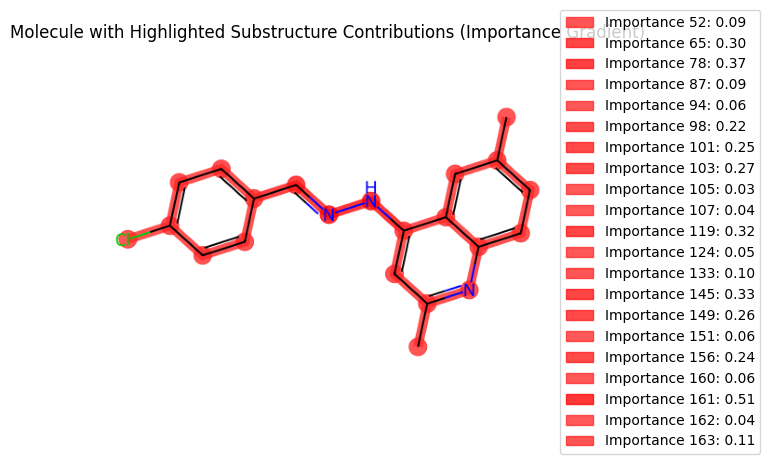

[12:41:01] SMARTS Parse Error: syntax error while parsing: ?
[12:41:01] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'
[12:41:01] SMARTS Parse Error: syntax error while parsing: ?
[12:41:01] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'
[12:41:01] SMARTS Parse Error: syntax error while parsing: ?
[12:41:01] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


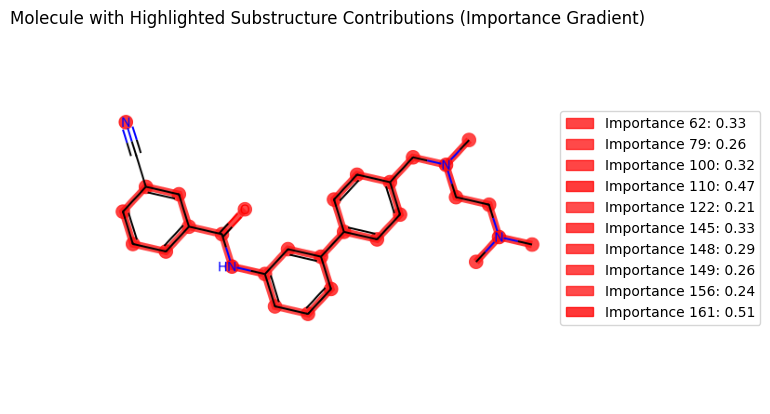

[12:41:01] SMARTS Parse Error: syntax error while parsing: ?
[12:41:01] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'
[12:41:01] SMARTS Parse Error: syntax error while parsing: ?
[12:41:01] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'
[12:41:01] SMARTS Parse Error: syntax error while parsing: ?
[12:41:01] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


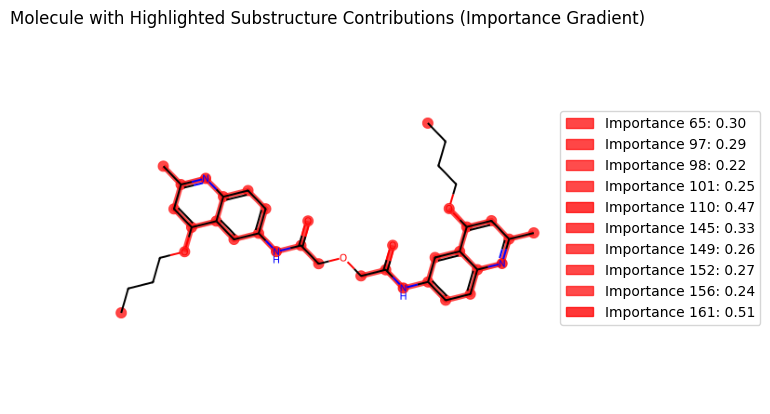

In [13]:
def predict_and_visualize_from_smiles(smiles, model, threshold=0.1):
    predicted_class, contributions = predict_and_compute_contributions(model, smiles)
    visualize_molecule_with_importance_gradient(smiles=smiles, contributions=contributions, threshold=threshold)


# # Visualize molecule with highlighted contributions
# print(f"Predicted Class: {'DD2 Inhibitor' if predicted_class else 'DD2 Non-Inhibitor'}")

# print(predicted_class, contributions)
predict_and_visualize_from_smiles(smiles=train_smiles[15], model=model, threshold=0.001)
predict_and_visualize_from_smiles(smiles=val_smiles[15], model=model, threshold=0.2)
predict_and_visualize_from_smiles(smiles=test_smiles[1], model=model, threshold=0.2)

In [ ]:
s=get_maccs_substructures()

In [ ]:
def get_maccs_smarts():
    patts = MACCSkeys.smartsPatts
    return [[f"maccs_{k}",patts[k][0]]  for k in patts if not k in [1, 125, 166]]

get_maccs_smarts()